In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

/home/whalenlex/.local/share/virtualenvs/jpdf-to-txt-x2aoK0lp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from natsort import natsorted

# get labels and file paths
file_paths = []
train_img_path = "train_imgs/"
file_paths = os.listdir(train_img_path)

# Sort the files using natural sorting
file_paths = natsorted(file_paths)
print(len(file_paths))


46260


In [3]:
import pandas as pd
df = pd.read_csv('samples.csv')

In [4]:
df

,string
0,ぁ
1,あ
2,ぃ
3,い
4,ぅ
...,...
46255,脇
46256,惑
46257,枠
46258,湾


In [5]:
df['path'] = file_paths

In [6]:
class_dict = {e:i for i,e in enumerate(df['string'].unique())}

In [7]:
len(class_dict.items())

2313

In [8]:
class_count = len(df['string'].unique())

In [9]:
class_count

2313

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
df['index'] = df['string'].apply(lambda x : class_dict[x])

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a custom PyTorch dataset
class OCRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join('train_imgs',self.dataframe.iloc[idx]['path'])
        label = self.dataframe.iloc[idx]['index']

        # Load and preprocess the image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            img = self.transform(img)

        return {
            'imgs':img,
            'labels':label
        }

# Define transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [14]:
# Create instances of the dataset for training and validation
train_dataset = OCRDataset(train_df, transform=transform)
val_dataset = OCRDataset(val_df, transform=transform)

# Create PyTorch data loaders
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
classes = list(df['string'].unique())

In [16]:
int_to_char = {v:k for k,v in class_dict.items()}

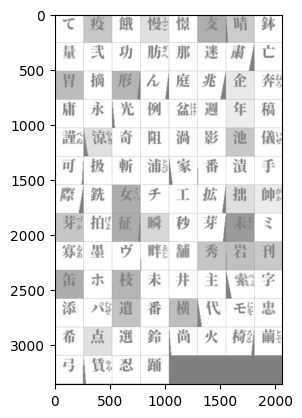

['て',
 '疫',
 '餓',
 '慢',
 '憬',
 '支',
 '晴',
 '鉢',
 '量',
 '弐',
 '功',
 '肪',
 '那',
 '迷',
 '粛',
 '亡',
 '胃',
 '摘',
 '形',
 'ん',
 '庭',
 '兆',
 '企',
 '奔',
 '庸',
 '永',
 '光',
 '例',
 '盆',
 '週',
 '年',
 '稿',
 '謹',
 '涼',
 '奇',
 '阻',
 '渦',
 '影',
 '池',
 '儀',
 '可',
 '扱',
 '斬',
 '浦',
 '家',
 '番',
 '漬',
 '手',
 '際',
 '銑',
 '女',
 'チ',
 '工',
 '拡',
 '拙',
 '帥',
 '芽',
 '拍',
 '征',
 '瞬',
 '秒',
 '芽',
 '未',
 'ミ',
 '寡',
 '墨',
 'ヴ',
 '畔',
 '舗',
 '秀',
 '岩',
 '刊',
 '缶',
 'ホ',
 '枝',
 '未',
 '井',
 '主',
 '索',
 '字',
 '添',
 'パ',
 '遺',
 '番',
 '横',
 '代',
 'モ',
 '忠',
 '希',
 '点',
 '選',
 '鈴',
 '尚',
 '火',
 '椅',
 '繭',
 '弓',
 '賃',
 '忍',
 '踊']

In [17]:
# 画像の表示
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 学習画像をランダムに取得
dataiter = iter(train_loader)
item = next(dataiter)
# 画像の表示
imshow(torchvision.utils.make_grid(item['imgs']))
# バッチサイズの表示
[int_to_char[i.item()] for i in item['labels']]

In [18]:
item['imgs'].shape

torch.Size([100, 1, 256, 256])

shape: torch.Size([256, 256])
label: て


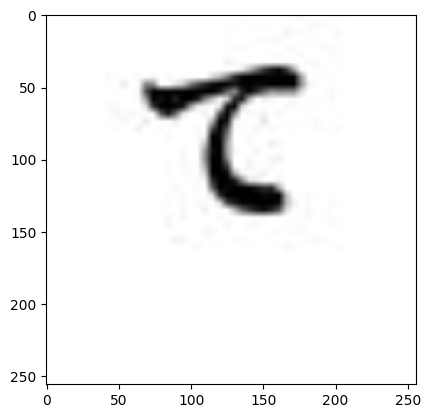

In [19]:
image_data = np.squeeze(item['imgs'][0])
print(f'shape: {image_data.shape}')
print(f'label: {int_to_char[item["labels"][0].item()]}')


plt.imshow(image_data, cmap='gray')
plt.show()


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output the number of classes
        self.out = nn.Linear(131072,len(classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0),-1)
        output = self.out(x)

        return output

In [21]:
cnn = Net()

In [22]:
from torch import optim

In [23]:
import torch.cuda as cuda

In [24]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

def train(num_epochs, cnn, train_loader, device):
    cnn = cnn.to(device)
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    cnn.train()
    total_step = len(train_loader)
    accumulated_loss = 0

    for epoch in range(num_epochs):
        for i, e in enumerate(train_loader):
            imgs = e['imgs']
            labels = e['labels']
            b_x = Variable(imgs).to(device)
            b_y = Variable(labels).to(device)

            output = cnn(b_x)

            loss = loss_fn(output, b_y)

            # clear grads
            optimizer.zero_grad()
            
            # backprop
            loss.backward()

            # apply grads
            optimizer.step()
        print(f'e: {epoch}, l: {loss}')


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [26]:
num_epochs = 100

In [27]:
train(num_epochs,cnn,train_loader,device)

e: 0, l: 0.9022879600524902
e: 1, l: 0.00014421674131881446
e: 2, l: 0.07648174464702606
e: 3, l: 0.0037375541869550943
e: 4, l: 4.335727135185152e-05
e: 5, l: 1.7434304027119651e-06
e: 6, l: 0.00034404234611429274
e: 7, l: 4.91737353058852e-07
e: 8, l: 5.2515752031467855e-05
e: 9, l: 4.6785400627413765e-05
e: 10, l: 2.7863519790116698e-05
e: 11, l: 2.2947631350689335e-06
e: 12, l: 1.7285287867707666e-06
e: 13, l: 0.0
e: 14, l: 6.854520506749395e-07
e: 15, l: 1.3411039390121005e-07
e: 16, l: 6.2136646192811895e-06
e: 17, l: 1.4901160305669237e-08
e: 18, l: 3.27825119939007e-07
e: 19, l: 1.192092469182171e-07
e: 20, l: 1.4603052704842412e-06
e: 21, l: 0.0002599813451524824
e: 22, l: 1.1920923270736239e-07
e: 23, l: 4.387623266666196e-05
e: 24, l: 6.765030775568448e-06
e: 25, l: 8.940693874137651e-08
e: 26, l: 1.6540183196411817e-06
e: 27, l: 1.8625123630044982e-05
e: 28, l: 0.0007210407056845725
e: 29, l: 2.9802318834981634e-08
e: 30, l: 0.0
e: 31, l: 5.8858854572463315e-06
e: 32, l: 2.

In [28]:
# Specify the file path where you want to save the model
model_path = 'ocr.pth'

# Save the model
torch.save(cnn.state_dict(), model_path)

In [29]:
def test(cnn,val_loader,device):
    # Test the model
    cnn = cnn.to(device)
    cnn.eval()    

    with torch.no_grad():
        for e in val_loader:
            imgs = e['imgs']
            labels = e['labels']
            imgs = imgs.to(device)
            labels = labels.to(device)
            test_output = cnn(imgs)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            print('Test Accuracy of the model on the test images: %.2f' % accuracy)
    

In [30]:
test(cnn,val_loader,device)

Test Accuracy of the model on the test images: 0.94
Test Accuracy of the model on the test images: 0.96
Test Accuracy of the model on the test images: 0.88
Test Accuracy of the model on the test images: 0.96
Test Accuracy of the model on the test images: 0.96
Test Accuracy of the model on the test images: 0.97
Test Accuracy of the model on the test images: 0.98
Test Accuracy of the model on the test images: 0.91
Test Accuracy of the model on the test images: 0.96
Test Accuracy of the model on the test images: 0.90
Test Accuracy of the model on the test images: 0.90
Test Accuracy of the model on the test images: 0.95
Test Accuracy of the model on the test images: 0.92
Test Accuracy of the model on the test images: 0.98
Test Accuracy of the model on the test images: 0.89
Test Accuracy of the model on the test images: 0.88
Test Accuracy of the model on the test images: 0.98
Test Accuracy of the model on the test images: 0.97
Test Accuracy of the model on the test images: 0.96
Test Accurac

In [31]:
sample = next(iter(val_loader))
imgs = sample['imgs']
labels = sample['labels']

In [102]:
sample_imgs = imgs[:100].to(device)

In [103]:
sample_labels = labels[:100].to(device)

In [104]:
test_output = cnn(sample_imgs)
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(f'Prediction number: {pred_y}')

Prediction number: [ 815 1548 2226 1034  451  187  158 1865  282 1068  471 1101  895  195
 1960 1614 2296 1807 1585 1718 1481  248 1195  616 2240  257 1190  478
  394 1452 1467 2213 1838   92  207 2239 2081 2004 2032 1843 1294  512
  307  637 1659 1172 1110 1368   20   64  152  398  905 1506  690  880
  262 1158 1545 1889 1332  903 1722  562 1015 1257  768  511 1628  517
  891  718 1094  176 1789  280 1016  250  229  757  685 2162 1886 1562
 1061  734  208  875 1939  856 2049  311  850  619 2279  793 1219 1566
  397  518]


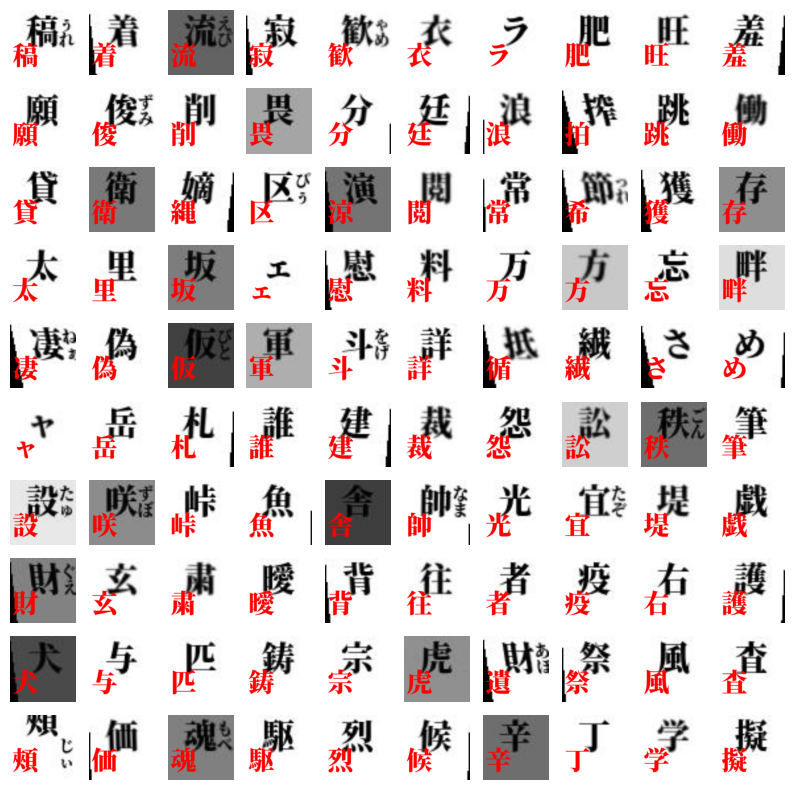

<Figure size 640x480 with 0 Axes>

In [106]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

# Assuming len(pred_y) and len(sample_imgs) are both 100 (10x10 grid)
grid_size = 10
font_path = "fonts/NotoSerifJP/NotoSerifJP-Black.otf"  # Replace with the path to your TTF font file
font_size = 100
font_color = (255, 0, 0)  # RGB color, replace with your desired color
font = ImageFont.truetype(font_path, font_size)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        index = i * grid_size + j
        pred_num, img = pred_y[index], sample_imgs[index]
        
        # Convert PyTorch tensor to NumPy array
        img_array = np.squeeze(img.cpu().numpy())

        # Convert to RGB
        img_array_rgb = np.stack((img_array,) * 3, axis=-1)

        # Convert to 8-bit unsigned integer array
        img_array_rgb = (img_array_rgb * 255).astype(np.uint8)
        
        # Display the image
        axes[i, j].imshow(img_array_rgb)
        axes[i, j].axis('off')  # Turn off axis labels and numbers

        # Convert prediction to Japanese characters (replace this with your actual conversion)
        japanese_prediction = int_to_char[pred_num]
        
        # Use Pillow to annotate the image with Japanese text
        img_pil = Image.fromarray(img_array_rgb)

        draw = ImageDraw.Draw(img_pil)

        # Calculate the position at the bottom of the image
        text_position = (10,100)

        draw.text(text_position, f'{japanese_prediction}', fill=font_color, font=font, font_size=font_size)

        axes[i, j].imshow(np.array(img_pil))


plt.savefig('predictions.png')
plt.show()